# Notebook 2 — Flood Year Classification :  “Will it flood?”

Build a binary classifier to predict whether a given station is associated with flood conditions, based on environmental, catchment, and hydrological features.

Notebook Setup

In [ ]:
# Imports
from google.colab import files
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
# Config
sns.set(style="whitegrid")
pd.set_option("display.max_columns", None)

print("Libraries loaded.")


Libraries loaded.


 Load Clean Dataset

In [ ]:

# Upload the ZIP file manually
uploaded = files.upload()


Saving ADHI_AnnualMax.zip to ADHI_AnnualMax.zip


In [ ]:
import zipfile
import os

zip_path = "ADHI_AnnualMax.zip"
extract_dir = "ADHI_AnnualMax/AnnualMax"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Files extracted to:", extract_dir)

Files extracted to: ADHI_AnnualMax


In [ ]:

import glob

# Define the correct relative path to the folder
extract_dir = "ADHI_AnnualMax/AnnualMax"
# Get all .txt files in the directory
file_paths = glob.glob(os.path.join(extract_dir, "*.txt"))

print(f" Found {len(file_paths)} .txt files.")
print(" Example files:", file_paths[:5])

 Found 1466 .txt files.
 Example files: ['ADHI_AnnualMax/AnnualMax/annualmax_ADHI_250.txt', 'ADHI_AnnualMax/AnnualMax/annualmax_ADHI_669.txt', 'ADHI_AnnualMax/AnnualMax/annualmax_ADHI_392.txt', 'ADHI_AnnualMax/AnnualMax/annualmax_ADHI_343.txt', 'ADHI_AnnualMax/AnnualMax/annualmax_ADHI_300.txt']


Parse All Files into a Combined DataFrame

In [ ]:

# Container to collect station data
annual_data_list = []

for path in file_paths:
    # Extract Station ID (e.g., from filename: annualmax_ADHI_999.txt → ADHI_999)
    filename = os.path.basename(path)
    station_id = filename.replace("annualmax_", "").replace(".txt", "")

    # Load the file
    df = pd.read_csv(path, header=None, names=["Year", "Month", "Day", "Max_Discharge"])

    # Add Station ID to each row
    df["Station_ID"] = station_id

    # Append to global list
    annual_data_list.append(df)

# Combine all into one big DataFrame
annual_max_df = pd.concat(annual_data_list, ignore_index=True)

# Preview the result
print("Combined annual max dataset shape:", annual_max_df.shape)
display(annual_max_df.head())


Combined annual max dataset shape: (32407, 5)


<ipython-input-14-2eddc9c0e989>:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  annual_max_df = pd.concat(annual_data_list, ignore_index=True)


,Year,Month,Day,Max_Discharge,Station_ID
0,1986,10,1,22.29,ADHI_250
1,1963,4,29,15.50,ADHI_669
2,1964,5,2,9.94,ADHI_669
3,1965,2,3,14.60,ADHI_669
4,1966,11,3,9.72,ADHI_669


Join with q95th from merged_df

In [ ]:
# Load cleaned, merged dataset
merged_df = pd.read_csv("ADHI_cleaned.csv")

# Show shape and first rows
print(f" Dataset shape: {merged_df.shape}")
display(merged_df.head())
merged_df.info()

# Quick column list
print(" Columns available:")
print(merged_df.columns.tolist())

 Dataset shape: (1466, 70)


,ID,Station_co,Name,Data_sourc,Catchment,Mean_altit,Maximum_al,Minimum_al,Mean_annual_precip,Mean_annual_pet,Mean_annual_temp,lc_forest,lc_urban,lc_crop,lc_crop_irrig,lc_grass,lc_shrub,lc_sparse,lc_bare,Starting_y,Ending_yea,Number_dams,Country,Longitude,Latitude,Flag,Comment,ADHI_ID,Mean_q,Std_q,Mini_q,Maxi_q,Jan_q,Feb_q,Mar_q,Apr_q,May_q,Jun_q,Jul_q,Aug_q,Sep_q,Oct_q,Nov_q,Dec_q,q5th,q10th,q25th,q50th,q75th,q90th,q95th,q99th,BFI_LH,BFI_UKIH,BaseflowR,BaseflowM_LH,BaseflowM_UKIH,CoV,HFD_mean,HFI_mean,AC1,AC7,PeakDistri,FlashI,MRC_num,Q_skew,Q_var,RLD,VariI,Freq_0
0,ADHI_1,CMQ0001,VINA NORD (BINI) a PONT DE BEREM,SIEREM,1566.639483,1111.0,1241,926,1492.93,1201.01,23.07,0.81,0.01,0.11,0.0,0.00,0.08,0.0,0.0,1963,1980,0,Cameroon,13.9500,7.5500,0,,ADHI_1,26.51,23.11,1.97,218.0,10.84,7.67,5.46,7.72,14.65,20.78,40.18,54.84,64.48,46.94,25.79,15.41,4.48,5.46,8.96,18.10,39.09,58.59,71.51,98.45,0.73,0.82,0.02,45.01,50.38,0.87,156.71,80.94,0.97,0.84,-1.79,0.08,2.0,1.63,534.25,0.42,0.35,0.0
1,ADHI_2,CMQ5002,KADEY a PANA,SIEREM,20015.853570,723.1,1015,602,1548.05,1059.42,24.17,0.88,0.00,0.07,0.0,0.04,0.00,0.0,0.0,1974,1992,0,Cameroon,14.6833,4.2000,1,gap filling,ADHI_2,213.48,163.25,16.50,904.0,141.65,93.76,84.99,101.61,134.79,162.31,164.20,196.33,354.81,475.21,429.01,218.69,48.24,62.50,100.00,163.00,274.00,443.80,575.65,757.13,0.75,0.90,0.02,308.50,396.69,0.76,177.75,94.56,1.00,0.94,-2.53,0.03,1.0,1.55,26649.83,0.19,0.27,0.0
2,ADHI_3,CMQ5004,DJA a BIE,SIEREM,19054.606070,674.5,779,569,1625.85,939.79,24.11,0.96,0.00,0.04,0.0,0.00,0.00,0.0,0.0,1972,1992,0,Cameroon,13.3500,2.8000,1,gap filling,ADHI_3,212.57,159.95,5.98,736.0,97.66,64.67,76.76,141.78,202.81,227.73,176.45,149.15,286.39,450.86,461.28,220.11,36.20,49.10,85.80,167.00,309.00,463.20,536.00,643.00,0.72,0.89,0.04,336.56,443.43,0.75,202.60,126.35,1.00,0.93,-2.21,0.03,3.0,0.97,25583.17,0.13,0.32,0.0
3,ADHI_4,CMQ0008,DOUME a DOUME,SIEREM,668.976076,690.8,713,654,1563.54,1033.94,24.08,0.80,0.00,0.20,0.0,0.00,0.00,0.0,0.0,1950,1980,0,Cameroon,13.4500,4.2333,0,,ADHI_4,6.04,3.24,0.27,25.6,4.14,3.60,3.89,4.44,5.75,6.62,5.59,4.77,7.80,10.51,9.21,6.05,1.72,2.19,3.55,5.44,7.92,10.69,12.00,14.89,0.77,0.82,0.04,6.04,6.66,0.54,190.53,139.03,0.98,0.78,-1.49,0.07,2.0,0.76,10.51,0.30,0.22,0.0
4,ADHI_5,CMQ5009,FARO a DJELEPO,SIEREM,24217.487570,701.8,1617,244,1464.63,1283.24,24.01,0.82,0.00,0.08,0.0,0.01,0.09,0.0,0.0,1954,1995,0,Cameroon,12.8167,8.6500,0,,ADHI_5,305.41,411.20,0.00,3350.0,27.33,11.37,5.80,12.53,49.74,170.33,484.95,761.57,1011.28,615.65,150.98,47.11,0.95,2.34,16.85,89.50,501.00,883.50,1140.00,1709.00,0.60,0.67,0.06,691.70,685.05,1.35,130.22,49.14,0.94,0.82,-2.42,0.18,2.0,1.85,169086.46,0.40,0.87,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1466 entries, 0 to 1465
Data columns (total 70 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  1466 non-null   object 
 1   Station_co          1466 non-null   object 
 2   Name                1466 non-null   object 
 3   Data_sourc          1466 non-null   object 
 4   Catchment           1466 non-null   float64
 5   Mean_altit          1466 non-null   float64
 6   Maximum_al          1466 non-null   int64  
 7   Minimum_al          1466 non-null   int64  
 8   Mean_annual_precip  1466 non-null   float64
 9   Mean_annual_pet     1466 non-null   float64
 10  Mean_annual_temp    1466 non-null   float64
 11  lc_forest           1466 non-null   float64
 12  lc_urban            1466 non-null   float64
 13  lc_crop             1466 non-null   float64
 14  lc_crop_irrig       1466 non-null   float64
 15  lc_grass            1466 non-null   float64
 16  lc_shr

In [ ]:
print("Missing values (top 10):")
missing = merged_df.isnull().sum()
display(missing[missing > 0].sort_values(ascending=False).head(10))


Missing values (top 10):


,0


In [ ]:
# Step 1: Extract station ID + q95th from summary_df
q95th_lookup = merged_df[["ADHI_ID", "q95th"]].copy()
q95th_lookup = q95th_lookup.rename(columns={"ADHI_ID": "Station_ID"})

# Step 2: Merge into annual max dataset
annual_max_df = annual_max_df.merge(q95th_lookup, on="Station_ID", how="left")
display(annual_max_df.head())

,Year,Month,Day,Max_Discharge,Station_ID,q95th
0,1986,10,1,22.29,ADHI_250,25.12
1,1963,4,29,15.50,ADHI_669,5.53
2,1964,5,2,9.94,ADHI_669,5.53
3,1965,2,3,14.60,ADHI_669,5.53
4,1966,11,3,9.72,ADHI_669,5.53


Define Target Variable: Flood Year

In [ ]:

# Step 3: Create flood_year label
annual_max_df["flood_year"] = (annual_max_df["Max_Discharge"] > annual_max_df["q95th"]).astype(int)

# Preview results
print("Added flood_year label:")
display(annual_max_df.head())

Added flood_year label:


,Year,Month,Day,Max_Discharge,Station_ID,q95th,flood_year
0,1986,10,1,22.29,ADHI_250,25.12,0
1,1963,4,29,15.50,ADHI_669,5.53,1
2,1964,5,2,9.94,ADHI_669,5.53,1
3,1965,2,3,14.60,ADHI_669,5.53,1
4,1966,11,3,9.72,ADHI_669,5.53,1


Class Distribution

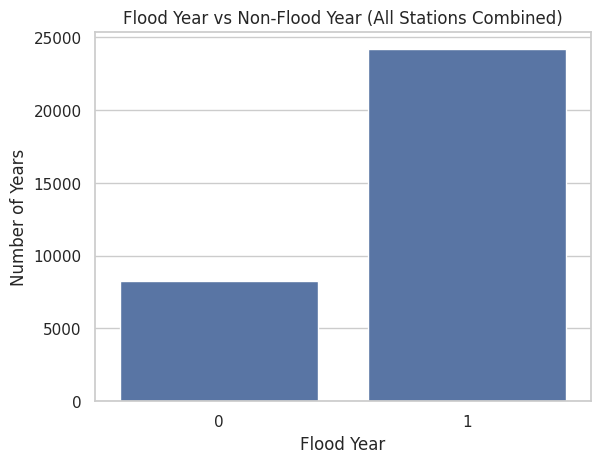

In [ ]:


sns.countplot(x="flood_year", data=annual_max_df)
plt.title("Flood Year vs Non-Flood Year (All Stations Combined)")
plt.xlabel("Flood Year")
plt.ylabel("Number of Years")
plt.show()


Static Features from merged_df

In [ ]:
# Step 1: Select useful columns from stations_df
static_features = merged_df[[
    "ID", "Catchment", "Mean_altit", "Maximum_al", "Minimum_al",
    "Mean_annual_precip", "Mean_annual_temp", "Mean_annual_pet",
    "lc_urban", "lc_forest", "lc_crop", "lc_crop_irrig",
    "lc_grass", "lc_shrub", "lc_sparse", "lc_bare",
    "Longitude", "Latitude", "Country", "Flag"
]].copy()

# Step 2: Rename for merge compatibility
static_features = static_features.rename(columns={"ID": "Station_ID"})

# Step 3: Merge with annual_max_df
flood_year_df = pd.merge(annual_max_df, static_features, on="Station_ID", how="left")

# Preview
print("Merged dataset shape:", flood_year_df.shape)
display(flood_year_df.head())


Merged dataset shape: (32407, 26)


,Year,Month,Day,Max_Discharge,Station_ID,q95th,flood_year,Catchment,Mean_altit,Maximum_al,Minimum_al,Mean_annual_precip,Mean_annual_temp,Mean_annual_pet,lc_urban,lc_forest,lc_crop,lc_crop_irrig,lc_grass,lc_shrub,lc_sparse,lc_bare,Longitude,Latitude,Country,Flag
0,1986,10,1,22.29,ADHI_250,25.12,0,364.399599,775.7,902,586,1474.64,25.01,1529.51,0.0,0.59,0.07,0.00,0.0,0.34,0.00,0.00,-11.955600,11.70560,Guinea,0
1,1963,4,29,15.50,ADHI_669,5.53,1,265.978791,2091.7,2973,1253,322.69,16.27,1402.01,0.0,0.26,0.18,0.01,0.0,0.15,0.35,0.05,-7.963338,31.29224,Morocco,0
2,1964,5,2,9.94,ADHI_669,5.53,1,265.978791,2091.7,2973,1253,322.69,16.27,1402.01,0.0,0.26,0.18,0.01,0.0,0.15,0.35,0.05,-7.963338,31.29224,Morocco,0
3,1965,2,3,14.60,ADHI_669,5.53,1,265.978791,2091.7,2973,1253,322.69,16.27,1402.01,0.0,0.26,0.18,0.01,0.0,0.15,0.35,0.05,-7.963338,31.29224,Morocco,0
4,1966,11,3,9.72,ADHI_669,5.53,1,265.978791,2091.7,2973,1253,322.69,16.27,1402.01,0.0,0.26,0.18,0.01,0.0,0.15,0.35,0.05,-7.963338,31.29224,Morocco,0


In [ ]:
print("\n Missing values in flood_year_df:")
missing_summary = flood_year_df.isnull().sum().sort_values(ascending=False)
display(missing_summary[missing_summary > 0])


 Missing values in flood_year_df:


,0


In [ ]:
# Save to CSV
flood_year_df.to_csv('flood_year.csv', index=False)

 Select Features for Modeling

In [ ]:
# Catchment and topography
catchment_features = [
    "Catchment", "Mean_altit", "Maximum_al", "Minimum_al"
]

# Climate features
climate_features = [
    "Mean_annual_precip", "Mean_annual_temp", "Mean_annual_pet"
]

# Land cover (%)
land_cover_features = [
    "lc_urban", "lc_forest", "lc_crop", "lc_crop_irrig",
    "lc_grass", "lc_shrub", "lc_sparse", "lc_bare"
]

# Geolocation
geo_features = ["Longitude", "Latitude"]

# Optional: Quality flag
meta_features = ["Flag"]

# Combine all
model_features = (
    catchment_features +
    climate_features +
    land_cover_features +
    geo_features +
    meta_features
)


In [ ]:
# Input features
X = flood_year_df[model_features].copy()

# Target
y = flood_year_df["flood_year"]

Train/Test Split

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,      # maintain flood/non-flood balance
    random_state=42  # reproducibility
)

# Confirm the split
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

#  Class balance check
print("\nFlood year distribution in training set:")
print(y_train.value_counts(normalize=True))


Training set size: (25925, 18)
Test set size: (6482, 18)

Flood year distribution in training set:
flood_year
1    0.745959
0    0.254041
Name: proportion, dtype: float64


 Model Training (exemple Random Forest)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Initialize and train the model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]  # Probabilities for ROC AUC


 Evaluation

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.36      0.44      1647
           1       0.81      0.92      0.86      4835

    accuracy                           0.77      6482
   macro avg       0.70      0.64      0.65      6482
weighted avg       0.75      0.77      0.75      6482

 ROC AUC Score: 0.772


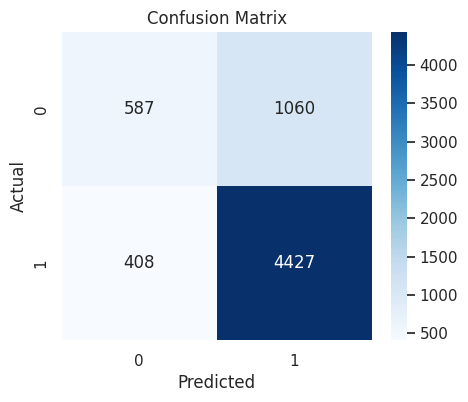

In [ ]:
# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# ROC AUC
roc_auc = roc_auc_score(y_test, y_prob)
print(f" ROC AUC Score: {roc_auc:.3f}")

# Confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Feature Importance


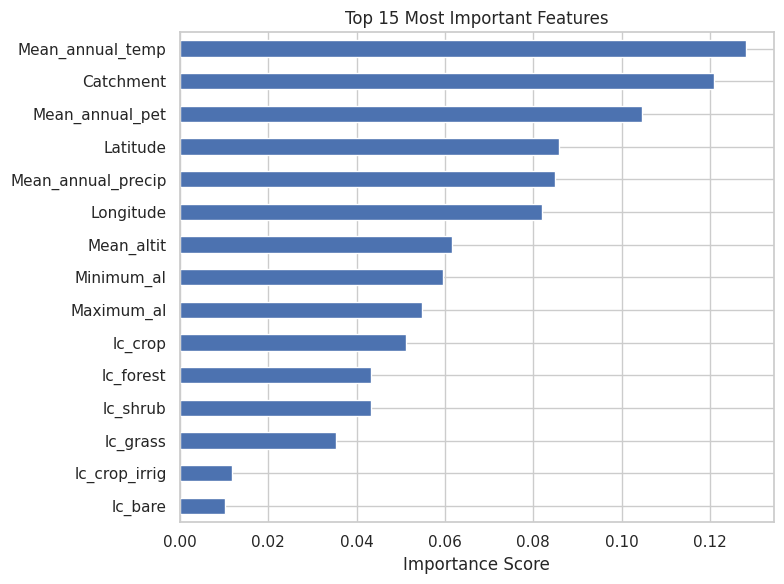

In [ ]:
# Create a Series of feature importances
importances = pd.Series(clf.feature_importances_, index=X_train.columns)

# Plot top 15
top_n = 15
importances.sort_values(ascending=False).head(top_n).plot(kind="barh", figsize=(8, 6))
plt.gca().invert_yaxis()
plt.title(f"Top {top_n} Most Important Features")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


- Temperature + PET being top features tells a story of climate-driven extremes, not just rainfall.

- Latitude/Longitude emphasize geographical hydrology — different basins behave very differently.

- Crop-related features matter more than urbanization, possibly because rural flooding dominates the dataset.

This also aligns with Africa’s limited urban hydrometric coverage, especially in informal areas.

Retrain the Random Forest with class_weight

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Re-initialize with class_weight
clf_balanced = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight="balanced"
)

# Train
clf_balanced.fit(X_train, y_train)

# Predict
y_pred_balanced = clf_balanced.predict(X_test)
y_prob_balanced = clf_balanced.predict_proba(X_test)[:, 1]


Classification Report (Balanced RF):
              precision    recall  f1-score   support

           0       0.45      0.70      0.55      1647
           1       0.87      0.71      0.78      4835

    accuracy                           0.71      6482
   macro avg       0.66      0.71      0.67      6482
weighted avg       0.77      0.71      0.72      6482

ROC AUC Score: 0.772215598038237


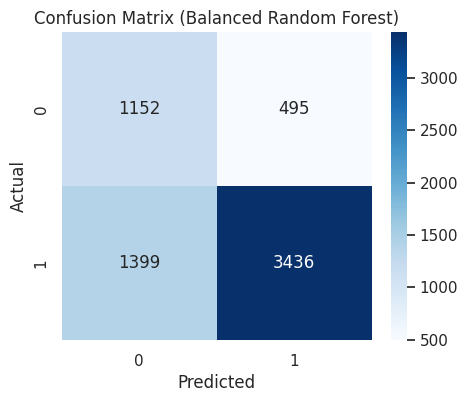

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Report
print("Classification Report (Balanced RF):")
print(classification_report(y_test, y_pred_balanced))

# AUC
print("ROC AUC Score:", roc_auc_score(y_test, y_prob_balanced))

# Confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_balanced), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Balanced Random Forest)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


The balanced model sacrifices some flood-year sensitivity to greatly improve non-flood detection.

This is often what we want for infrastructure design, insurance, or long-term flood exposure mapping, where over-alerting is costly.

For early-warning systems, you might prefer the unbalanced model (high recall for class 1).



Train XGBoost Classifier

In [ ]:
!pip install xgboost -q


In [ ]:
# Needed for scale_pos_weight
from collections import Counter

counter = Counter(y_train)
neg, pos = counter[0], counter[1]
imbalance_ratio = neg / pos

print(f" Class Imbalance Ratio (scale_pos_weight): {imbalance_ratio:.2f}")


 Class Imbalance Ratio (scale_pos_weight): 0.34


Train XGBoost Model

In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Initialize model with imbalance handling
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    scale_pos_weight=imbalance_ratio,
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"  # suppress warning
)

# Fit model
xgb_model.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:32:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


 Evaluate the XGBoost Classifier

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.69      0.55      1647
           1       0.87      0.71      0.78      4835

    accuracy                           0.71      6482
   macro avg       0.66      0.70      0.66      6482
weighted avg       0.76      0.71      0.72      6482

ROC AUC Score: 0.773529886371699


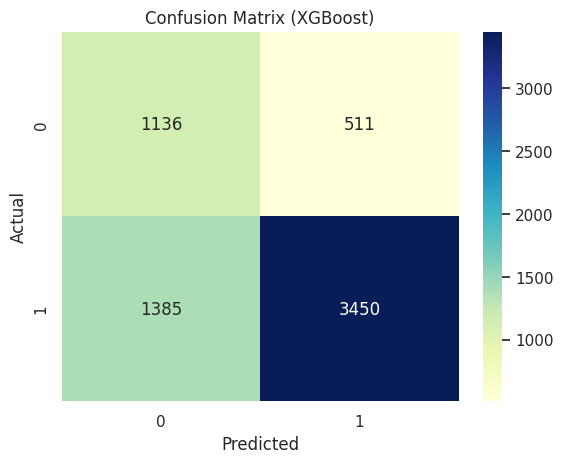

In [ ]:
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

print("ROC AUC Score:", roc_auc_score(y_test, y_prob_xgb))

# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix (XGBoost)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Save Model or Feature Set

In [ ]:
import joblib


In [ ]:
joblib.dump(clf, "flood_rf_unbalanced.pkl")
joblib.dump(clf_balanced, "flood_rf_balanced.pkl")

['flood_rf_balanced.pkl']